# AutoML Image Classification: With Rotation (Digits)

![](imgs/rotation.png)

In [1]:
import random as rn
from abc import ABC, abstractmethod

import autokeras as ak
import h2o
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import torch
from h2o.automl import H2OAutoML
from numpy.random import RandomState
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tpot import TPOTClassifier

from dpemu import runner
from dpemu.filters.image import RotationPIL
from dpemu.nodes import Array
from dpemu.nodes.series import Series
from dpemu.plotting_utils import visualize_scores, print_results_by_model
from dpemu.utils import generate_tmpdir

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [2]:
def get_data():
    random_state = RandomState(42)
    digits = load_digits()
    return train_test_split(digits["data"], digits["target"], test_size=.2, random_state=random_state)

In [3]:
def get_err_root_node():
    err_img_node = Array(reshape=(8, 8))
    err_root_node = Series(err_img_node)
    err_img_node.addfilter(RotationPIL("max_angle"))
    return err_root_node

In [4]:
def get_err_params_list():
    angle_steps = np.linspace(0, 84, num=8)
    err_params_list = [{"max_angle": a} for a in angle_steps]
    return err_params_list

In [5]:
class Preprocessor:

    def run(self, train_data, test_data, params):
        return train_data, test_data, {}

In [6]:
class AbstractModel(ABC):

    def __init__(self):
        self.time_limit_mins = 60*2
        self.seed = 42
        self.random_state = RandomState(self.seed)
        np.random.seed(self.seed)
        tf.set_random_seed(self.seed)
        torch.manual_seed(self.seed)


    @abstractmethod
    def get_fitted_model(self, train_data, train_labels, params):
        pass

    @abstractmethod
    def get_accuracy(self, data, labels, fitted_model, params):
        pass

    @abstractmethod
    def get_best_pipeline(self, fitted_model):
        pass

    def run(self, train_data, test_data, params):
        train_labels = params["train_labels"]
        test_labels = params["test_labels"]

        fitted_model = self.get_fitted_model(train_data, train_labels, params)

        return {
            "test_acc": self.get_accuracy(test_data, test_labels, fitted_model, params),
            "train_acc": self.get_accuracy(train_data, train_labels, fitted_model, params),
            "best_pipeline": self.get_best_pipeline(fitted_model),
        }

class TPOTClassifierModel(AbstractModel):

    def __init__(self):
        super().__init__()

    def get_fitted_model(self, train_data, train_labels, params):
        return TPOTClassifier(
            max_time_mins=self.time_limit_mins,
            n_jobs=-1,
            random_state=self.seed,
            verbosity=1,
        ).fit(train_data, train_labels)
    
    def get_accuracy(self, data, labels, fitted_model, params):
        return round(fitted_model.score(data, labels), 3)

    def get_best_pipeline(self, fitted_model):
        return [step[1] for step in fitted_model.fitted_pipeline_.steps]

class H2OAutoMLModel(AbstractModel):

    def __init__(self):
        super().__init__()
        h2o.init(name=f"#{rn.SystemRandom().randint(1, 2**30)}")
        h2o.no_progress()

    def get_fitted_model(self, train_data, train_labels, params):
        train_data = h2o.H2OFrame(np.concatenate((train_data, train_labels.reshape(-1, 1)), axis=1))
        x = np.array(train_data.columns)[:-1].tolist()
        y = np.array(train_data.columns)[-1].tolist()
        train_data[y] = train_data[y].asfactor()
        aml = H2OAutoML(max_runtime_secs=60*self.time_limit_mins, seed=self.seed)
        aml.train(x=x, y=y, training_frame=train_data)
        return aml

    def get_accuracy(self, data, labels, fitted_model, params):
        data = h2o.H2OFrame(np.concatenate((data, labels.reshape(-1, 1)), axis=1))
        y = np.array(data.columns)[-1].tolist()
        data[y] = data[y].asfactor()
        pred = fitted_model.predict(data).as_data_frame(header=False)["predict"].values.astype(int)
        return np.round(np.mean(pred == labels), 3)

    def get_best_pipeline(self, fitted_model):
        leader_params = fitted_model.leader.get_params()
        best_pipeline = [leader_params["model_id"]["actual_value"]["name"]]
        if "base_models" in leader_params:
            for base_model in leader_params["base_models"]["actual_value"]:
                best_pipeline.append(base_model["name"])
        h2o.cluster().shutdown()
        return best_pipeline

class AutoKerasModel(AbstractModel):

    def __init__(self):
        super().__init__()

    def get_fitted_model(self, x_train, y_train, params):
        s = np.sqrt(x_train.shape[1]).astype(int)
        x_train = x_train.reshape((len(x_train), s, s)).astype(np.uint8)
        x_train = x_train.reshape(x_train.shape + (1,))
        y_train = y_train.astype(np.uint8)
        clf = ak.ImageClassifier(augment=False, path=generate_tmpdir(), verbose=False)
        clf.fit(x_train, y_train, time_limit=60*self.time_limit_mins)
        return clf

    def get_accuracy(self, x, y, clf, params):
        s = np.sqrt(x.shape[1]).astype(int)
        x = x.reshape((len(x), s, s)).astype(np.uint8)
        x = x.reshape(x.shape + (1,))
        y = y.astype(np.uint8)
        y_pred = clf.predict(x)
        return np.round(accuracy_score(y_true=y, y_pred=y_pred), 3)

    def get_best_pipeline(self, clf):
        return [m for i, m in enumerate(clf.cnn.best_model.produce_model().modules()) if i > 0]

In [7]:
def get_model_params_dict_list(train_labels, test_labels):
    model_params_base = {"train_labels": train_labels, "test_labels": test_labels}
    return [
        {
            "model": TPOTClassifierModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        {
            "model": TPOTClassifierModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": True
        },
        {
            "model": H2OAutoMLModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        {
            "model": H2OAutoMLModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": True
        },
        {
            "model": AutoKerasModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        {
            "model": AutoKerasModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": True
        },
    ]

In [8]:
def visualize(df):
    visualize_scores(
        df,
        score_names=["test_acc", "train_acc"],
        is_higher_score_better=[True, True],
        err_param_name="max_angle",
        title="Classification scores with added error"
    )
    plt.show()

In [9]:
train_data, test_data, train_labels, test_labels = get_data()

df = runner.run(
    train_data=train_data,
    test_data=test_data,
    preproc=Preprocessor,
    preproc_params=None,
    err_root_node=get_err_root_node(),
    err_params_list=get_err_params_list(),
    model_params_dict_list=get_model_params_dict_list(train_labels, test_labels),
)

  0%|          | 0/8 [00:00<?, ?it/s]

Checking whether there is an H2O instance running at http://localhost:54321 

.

Checking whether there is an H2O instance running at http://localhost:54321 

.

Checking whether there is an H2O instance running at http://localhost:54321 

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

Checking whether there is an H2O instance running at http://localhost:54321 

.

Checking whether there is an H2O instance running at http://localhost:54321 

.

Checking whether there is an H2O instance running at http://localhost:54321 

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

 not found.

 not found.

Attempting to start a local H2O server...

Attempting to start a local H2O server...

 not found.

 not found.

 not found.

Attempting to start a local H2O server...

Attempting to start a local H2O server...

Attempting to start a local H2O server...

 not found.

Attempting to start a local H2O server...

 not found.

 not found.

Attempting to start a local H2O server...

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Ice root: /wrk/users/thalvari/tmp1q960lyd

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpyep6k758

  Ice root: /wrk/users/thalvari/tmp6scl_qb3

  JVM stdout: /wrk/users/thalvari/tmp1q960lyd/h2o_thalvari_started_from_python.out

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  JVM stderr: /wrk/users/thalvari/tmp1q960lyd/h2o_thalvari_started_from_python.err

  JVM stdout: /wrk/users/thalvari/tmpyep6k758/h2o_thalvari_started_from_python.out

  JVM stdout: /wrk/users/thalvari/tmp6scl_qb3/h2o_thalvari_started_from_python.out

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  JVM stderr: /wrk/users/thalvari/tmp6scl_qb3/h2o_thalvari_started_from_python.err

  Ice root: /wrk/users/thalvari/tmp8ltjrc2c

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  JVM stdout: /wrk/users/thalvari/tmp8ltjrc2c/h2o_thalvari_started_from_python.out

  Ice root: /wrk/users/thalvari/tmpwvgkwdrq

  JVM stderr: /wrk/users/thalvari/tmpyep6k758/h2o_thalvari_started_from_python.err

  JVM stderr: /wrk/users/thalvari/tmp8ltjrc2c/h2o_thalvari_started_from_python.err

  JVM stdout: /wrk/users/thalvari/tmpwvgkwdrq/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpwvgkwdrq/h2o_thalvari_started_from_python.err

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp_q6f3jla

  JVM stdout: /wrk/users/thalvari/tmp_q6f3jla/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp_q6f3jla/h2o_thalvari_started_from_python.err

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpqzja0x6f

  Ice root: /wrk/users/thalvari/tmp0y17ib2s

  JVM stdout: /wrk/users/thalvari/tmpqzja0x6f/h2o_thalvari_started_from_python.out

  JVM stdout: /wrk/users/thalvari/tmp0y17ib2s/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpqzja0x6f/h2o_thalvari_started_from_python.err

  JVM stderr: /wrk/users/thalvari/tmp0y17ib2s/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54333

Connecting to H2O server at http://127.0.0.1:54333 ..

.

  Server is running at http://127.0.0.1:54321

  Server is running at http://127.0.0.1:54327

Connecting to H2O server at http://127.0.0.1:54321 ..

.

Connecting to H2O server at http://127.0.0.1:54327 ..

.

 successful.

  Server is running at http://127.0.0.1:54325

Connecting to H2O server at http://127.0.0.1:54325 ..

.

  Server is running at http://127.0.0.1:54323

Connecting to H2O server at http://127.0.0.1:54323 ..

.

  Server is running at http://127.0.0.1:54331

 successful.

  Server is running at http://127.0.0.1:54329

Connecting to H2O server at http://127.0.0.1:54331 ..

.

Connecting to H2O server at http://127.0.0.1:54329 ..

.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,3 days
H2O cluster name:,#112958621
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


 successful.

 successful.

  Server is running at http://127.0.0.1:54335

Connecting to H2O server at http://127.0.0.1:54335 ..

.

H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,3 days
H2O cluster name:,#319393266
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


 successful.

 successful.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,3 days
H2O cluster name:,#617629525
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,3 days
H2O cluster name:,#350419230
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,3 days
H2O cluster name:,#821171675
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,3 days
H2O cluster name:,#569402538
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,3 days
H2O cluster name:,#155615091
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,3 days
H2O cluster name:,#683639840
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_b57a closed.

H2O session _sid_aaf2 closed.

H2O session _sid_895e closed.

H2O session _sid_8e14 closed.

H2O session _sid_93dc closed.

H2O session _sid_8630 closed.

H2O session _sid_b515 closed.

 12%|█▎        | 1/8 [59:01<6:53:13, 3541.97s/it]

H2O session _sid_adcf closed.

 62%|██████▎   | 5/8 [59:08<2:03:59, 2479.86s/it]

100%|██████████| 8/8 [59:08<00:00, 443.56s/it]   

'H2OAutoML #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.986,1,0.204,0,3541.76
12,0.981,1,0.282,0,3497.2
24,0.953,1,0.321,0,3531.11
36,0.953,1,0.297,0,3538.41
48,0.936,1,0.24,0,3548.21
60,0.922,1,0.268,0,3526.75
72,0.936,1,0.27,0,3514.59
84,0.894,1,0.269,0,3456.55


max_angle,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16,pipe_17,pipe_18,pipe_19,pipe_20,pipe_21,pipe_22,pipe_23,pipe_24,pipe_25,pipe_26,pipe_27,pipe_28,pipe_29,pipe_30,pipe_31,pipe_32,pipe_33,pipe_34,pipe_35,pipe_36,pipe_37,pipe_38,pipe_39,pipe_40,pipe_41,pipe_42,pipe_43,pipe_44,pipe_45,pipe_46,pipe_47,pipe_48,pipe_49,pipe_50,pipe_51,pipe_52,pipe_53,pipe_54,pipe_55,pipe_56,pipe_57,pipe_58,pipe_59,pipe_60,pipe_61,pipe_62,pipe_63,pipe_64,pipe_65,pipe_66,pipe_67,pipe_68,pipe_69,pipe_70,pipe_71,pipe_72,pipe_73,pipe_74,pipe_75,pipe_76,pipe_77,pipe_78,pipe_79,pipe_80,pipe_81,pipe_82,pipe_83,pipe_84,pipe_85,pipe_86,pipe_87,pipe_88,pipe_89,pipe_90,pipe_91
0,StackedEnsemble_AllModels_AutoML_20191021_062318,DeepLearning_grid_1_AutoML_20191021_062318_model_2,DeepLearning_grid_1_AutoML_20191021_062318_model_8,GBM_grid_1_AutoML_20191021_062318_model_31,DeepLearning_grid_1_AutoML_20191021_062318_model_11,GBM_grid_1_AutoML_20191021_062318_model_18,DeepLearning_grid_1_AutoML_20191021_062318_model_3,GBM_grid_1_AutoML_20191021_062318_model_19,DeepLearning_grid_1_AutoML_20191021_062318_model_1,DeepLearning_grid_1_AutoML_20191021_062318_model_7,DeepLearning_grid_1_AutoML_20191021_062318_model_10,XGBoost_grid_1_AutoML_20191021_062318_model_13,GBM_grid_1_AutoML_20191021_062318_model_15,GBM_2_AutoML_20191021_062318,GBM_grid_1_AutoML_20191021_062318_model_3,GBM_grid_1_AutoML_20191021_062318_model_32,GBM_3_AutoML_20191021_062318,GBM_grid_1_AutoML_20191021_062318_model_26,GBM_grid_1_AutoML_20191021_062318_model_6,GBM_grid_1_AutoML_20191021_062318_model_27,GBM_grid_1_AutoML_20191021_062318_model_20,GBM_5_AutoML_20191021_062318,GBM_grid_1_AutoML_20191021_062318_model_12,GBM_4_AutoML_20191021_062318,GLM_grid_1_AutoML_20191021_062318_model_1,GBM_grid_1_AutoML_20191021_062318_model_17,XRT_1_AutoML_20191021_062318,GBM_grid_1_AutoML_20191021_062318_model_1,GBM_grid_1_AutoML_20191021_062318_model_10,XGBoost_grid_1_AutoML_20191021_062318_model_8,GBM_1_AutoML_20191021_062318,GBM_grid_1_AutoML_20191021_062318_model_14,GBM_grid_1_AutoML_20191021_062318_model_11,GBM_grid_1_AutoML_20191021_062318_model_16,GBM_grid_1_AutoML_20191021_062318_model_24,DRF_1_AutoML_20191021_062318,XGBoost_grid_1_AutoML_20191021_062318_model_17,DeepLearning_grid_1_AutoML_20191021_062318_model_5,DeepLearning_grid_1_AutoML_20191021_062318_model_6,GBM_grid_1_AutoML_20191021_062318_model_13,XGBoost_3_AutoML_20191021_062318,XGBoost_grid_1_AutoML_20191021_062318_model_30,DeepLearning_grid_1_AutoML_20191021_062318_model_12,XGBoost_1_AutoML_20191021_062318,XGBoost_grid_1_AutoML_20191021_062318_model_25,XGBoost_grid_1_AutoML_20191021_062318_model_21,XGBoost_grid_1_AutoML_20191021_062318_model_18,DeepLearning_grid_1_AutoML_20191021_062318_model_4,XGBoost_grid_1_AutoML_20191021_062318_model_26,XGBoost_grid_1_AutoML_20191021_062318_model_15,GBM_grid_1_AutoML_20191021_062318_model_8,GBM_grid_1_AutoML_20191021_062318_model_9,XGBoost_grid_1_AutoML_20191021_062318_model_20,XGBoost_grid_1_AutoML_20191021_062318_model_27,XGBoost_grid_1_AutoML_20191021_062318_model_4,XGBoost_grid_1_AutoML_20191021_062318_model_2,GBM_grid_1_AutoML_20191021_062318_model_29,XGBoost_grid_1_AutoML_20191021_062318_model_29,GBM_grid_1_AutoML_20191021_062318_model_28,XGBoost_grid_1_AutoML_20191021_062318_model_28,DeepLearning_grid_1_AutoML_20191021_062318_model_9,XGBoost_grid_1_AutoML_20191021_062318_model_3,XGBoost_grid_1_AutoML_20191021_062318_model_23,XGBoost_grid_1_AutoML_20191021_062318_model_7,XGBoost_grid_1_AutoML_20191021_062318_model_19,GBM_grid_1_AutoML_20191021_062318_model_25,GBM_grid_1_AutoML_20191021_062318_model_21,XGBoost_2_AutoML_20191021_062318,GBM_grid_1_AutoML_20191021_062318_model_30,GBM_grid_1_AutoML_20191021_062318_model_7,GBM_grid_1_AutoML_20191021_062318_model_23,XGBoost_grid_1_AutoML_20191021_062318_model_5,XGBoost_grid_1_AutoML_20191021_062318_model_22,XGBoost_grid_1_AutoML_20191021_062318_model_12,GBM_grid_1_AutoML_20191021_0

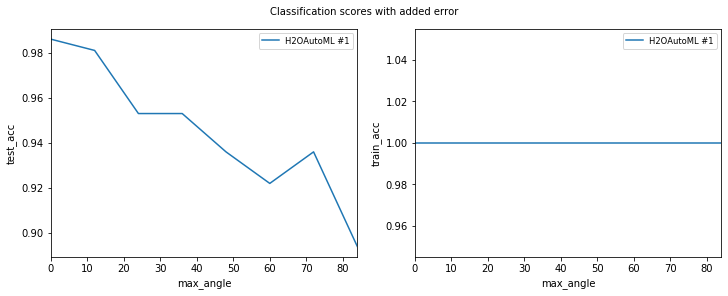

In [10]:
print_results_by_model(
    df, 
    ["train_labels", "test_labels"],
    err_param_name="max_angle",
    pipeline_name="best_pipeline",
)
visualize(df)